Computation of the Pascal triangle modulo some integer called 'base'.
If the integer is 2, this is also called the Sierpinski triangle.
The triangle is put in a square: what is usually a line is now a diagonal.

Usual Pascal triangle     

    1                         
    1 1                       
    1 2 1                     
    1 3 3 1                   
    1 4 6 4 1 

Pascal triangle in a square

    1 1 1 1 1
    1 2 3 4 5
    1 3 6 10
    1 4 10
    1 5 15

Two dimensional array s[][] such that
 - s[i][0] = s[O][i] = 1 for all i >= 0
 - s[i][j] = s[i-1][j] + s[i][j-1] mod base for all i,j >= 1

In [349]:
import matplotlib.pyplot as plt
import math
import itertools
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu

In [350]:


BASE = 2

class PascalModulo:
    def __init__(self,base):
        self.base = base
        self.diags = [[1]]
        
    #Add a diagonal and fill it
    def _add(self):
        self.diags[0].append(1)
        i = 1
        while i <= len(self.diags) - 1:
            self.diags[i].append( (self.diags[i-1][len(self.diags[i])] + self.diags[i][len(self.diags[i]) - 1]) % self.base )
            i+=1
        self.diags.append([1])
            
    #Get element
    def get(self,i,j):
        if (i < 1 or j < 1):
            return 1
        # Compute diagonal if not computed yet
        while (len(self.diags[0]) <= i+j):
            self._add()
        return self.diags[i][j]
    
    
    

In [2]:
sierp = PascalModulo(BASE)
sierp.get(7,7)
sierp.diags

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
 [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1],
 [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1],
 [1, 0, 1, 0, 1, 0],
 [1, 1, 0, 0, 1],
 [1, 0, 0, 0],
 [1, 1, 1],
 [1, 0],
 [1]]

In [351]:

class Levin:
    
    def __init__(self,size=1):
        self.size = size
        self.iterator = itertools.product([False, True], repeat=self.size)
        self.block = next(self.iterator)
        self.block_index = 0
        self.sierp = PascalModulo(2)
    
    def get_next_digit(self):
#       print('block: ' + str(self.block) + ' ' + str(self.block_index))
        #check if the whole block was consumed and get a new one
        if len(self.block)  == self.block_index:
            try:
                self.block = next(self.iterator)
            except:
                self.size += 1
                self.iterator = itertools.product([False, True], repeat=self.size)
                self.block = next(self.iterator)
            self.block_index = 0
        res = 0
        for j in range(self.size):
            res += self.sierp.get(self.block_index,self.size-j-1) * self.block[j]
        self.block_index += 1
        return res%2
        
                
            
            
        

In [5]:
levin = Levin()
for i in range(10):
    print(levin.get_next_digit(), end = '')

0100111001

In [352]:
def get_occurrences(amounts,M):
    #returns frequency of occurencies for each value in the observed range
    occs = {}
    total = 0    
    for k,v in amounts.items():
        total += 1
        if v not in occs:
            occs[v] = 0
        occs[v] = occs[v] + 1
    occs[0] = int(2**M - total)
    max = 0
    for k,v in occs.items():
        occs[k] = v/2**M
#         occs[k] = v
        if k > max:
            max = k
    occs_array = [occs[i] if i in occs  else 0 for i in range(max+1)]
    return occs_array

   
def get_amounts_for_first(N,lamb=[1]):
    levin = Levin()
    lamb.sort()
    M = int(math.ceil(math.log(N,2)))
    
    #create dictionaries to store frequencies of every lambda value
    amounts = {}
    counter = 0
    word = ''
    occs = {}
    
    while len(word) < M:
        counter += 1
        word = word + str(levin.get_next_digit())
    amounts[word] = 1
    max_lamb = lamb[len(lamb) - 1]
    while counter < N*max_lamb:
#         print(counter)
        word = word[1:]
        word = word + str(levin.get_next_digit())
        if  word not in amounts:
            amounts[word] = 0
        amounts[word] = amounts[word] + 1
        counter += 1
        if counter == N*lamb[0]:
            occs[lamb.pop(0)] = get_occurrences(amounts,M)
            
    return occs
    

In [353]:
def analize_result(l, occs,plot=True):
    actual = np.array(occs)  
    M = int(math.ceil(math.log(N,2)))
    x= np.arange(0,len(occs),1)
#     p = list(map(lambda x: x*2**M ,poisson.pmf(x,l)))
    p = poisson.pmf(x,l)
#     print("lambda: " + str(l) + " chisquare: " + str(chisquare(f_obs=actual, f_exp=p,ddof=1)))
    print("MWU: " + str(mannwhitneyu(actual,p)))
    if(plot):
        plt.figure(l)
        plt.plot(x, p)
        p2 = plt.bar([i for i in range(len(occs))], p,label="expected")
        p1 = plt.bar([i for i in range(len(occs))], occs, color='#d62728',label="actual")
        plt.legend(loc='best')
        plt.show()
    

In [355]:
lamb = [i+1 for i in range(10,20)]
N = 2**20
occurrences = get_amounts_for_first(N,lamb=lamb)

MWU: MannwhitneyuResult(statistic=1129.0, pvalue=0.000216390158894885)


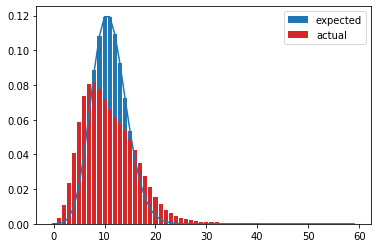

MWU: MannwhitneyuResult(statistic=1213.0, pvalue=0.00046159916173209)


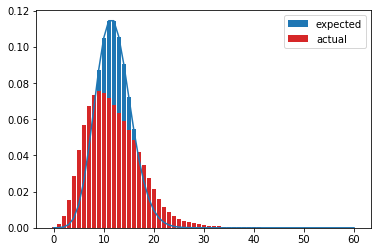

MWU: MannwhitneyuResult(statistic=1243.0, pvalue=0.0003484941023011539)


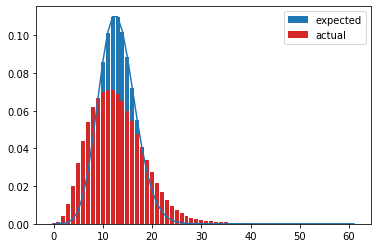

MWU: MannwhitneyuResult(statistic=1300.0, pvalue=0.00042286926643865443)


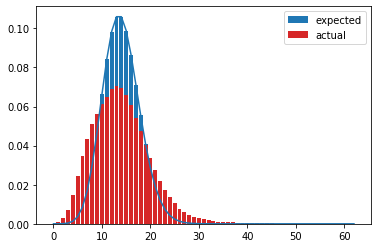

MWU: MannwhitneyuResult(statistic=1383.0, pvalue=0.0007707738481814183)


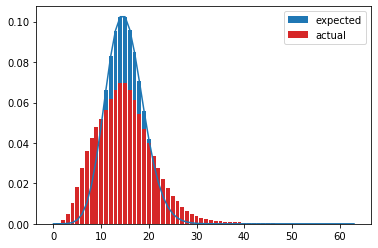

MWU: MannwhitneyuResult(statistic=1472.0, pvalue=0.0014410316125596022)


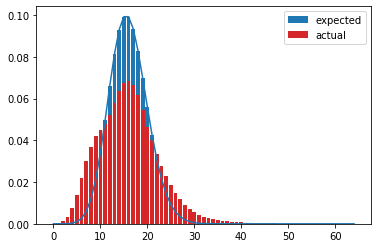

MWU: MannwhitneyuResult(statistic=1431.0, pvalue=0.0007596964895947917)


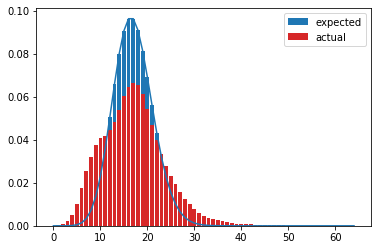

MWU: MannwhitneyuResult(statistic=1450.0, pvalue=0.0010263611824531157)


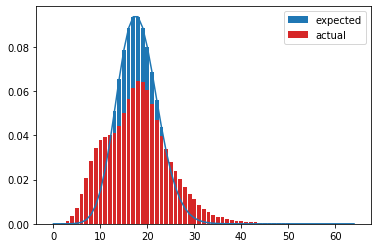

MWU: MannwhitneyuResult(statistic=1514.0, pvalue=0.0012651182840265663)


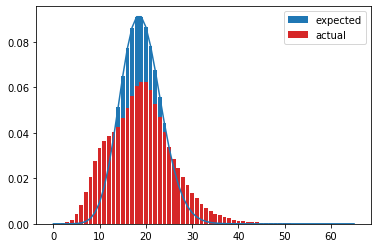

MWU: MannwhitneyuResult(statistic=1862.0, pvalue=0.000847730132970845)


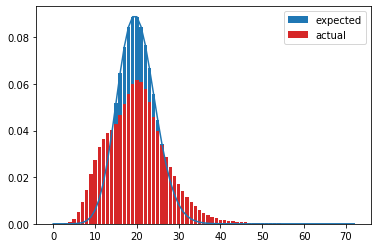

In [356]:
for k,v in occurrences.items():
    analize_result(k,v)

In [ ]:
lamb = [i+1 for i in range(10,20)]
N = 2**22
occurrences_2 = get_amounts_for_first(N,lamb=lamb)
for k,v in occurrences_2.items():
    analize_result(k,v)

4
MWU: MannwhitneyuResult(statistic=4.0, pvalue=0.5)


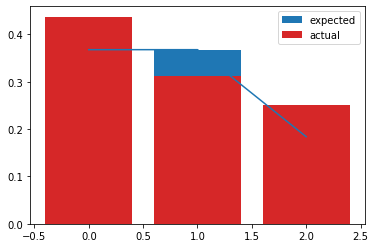

5
MWU: MannwhitneyuResult(statistic=4.0, pvalue=0.5)


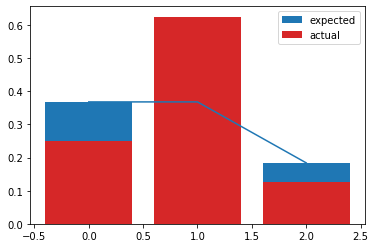

6
MWU: MannwhitneyuResult(statistic=7.0, pvalue=0.44227471942648117)


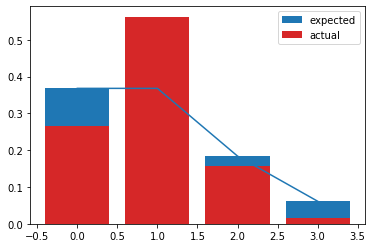

7
MWU: MannwhitneyuResult(statistic=12.0, pvalue=0.5)


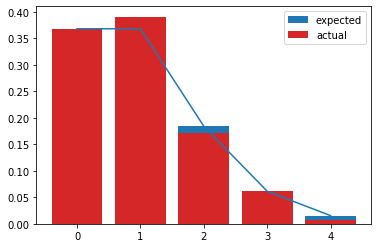

8
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)


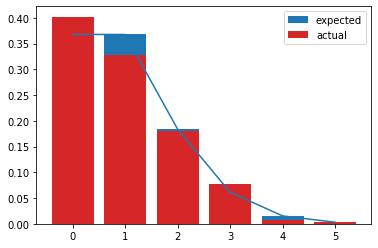

9
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)


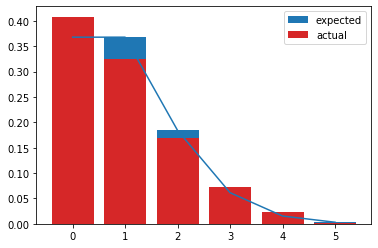

10
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)


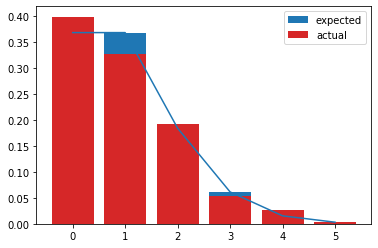

11
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)


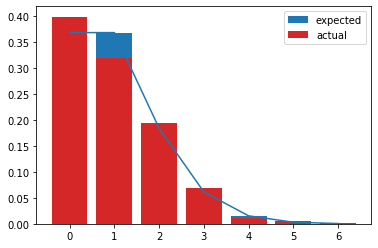

12
MWU: MannwhitneyuResult(statistic=36.0, pvalue=0.36189765707468813)


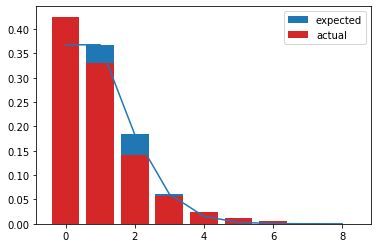

13
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2601830104482655)


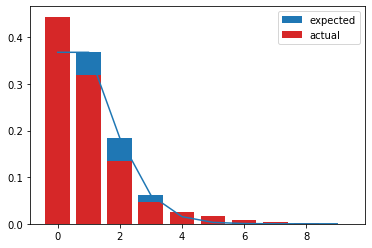

14
MWU: MannwhitneyuResult(statistic=62.0, pvalue=0.12953519666662766)


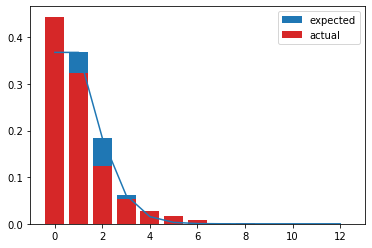

15
MWU: MannwhitneyuResult(statistic=94.0, pvalue=0.10330788479137654)


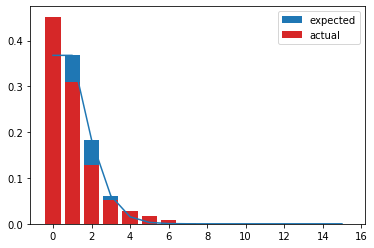

16
MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.05501505396695189)


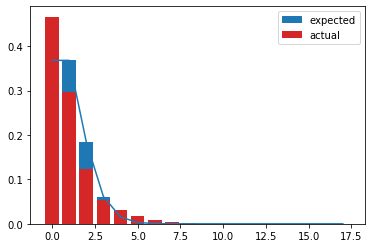

17
MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.02196446760514372)


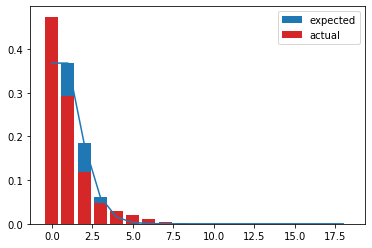

18
MWU: MannwhitneyuResult(statistic=127.0, pvalue=0.009650304089253232)


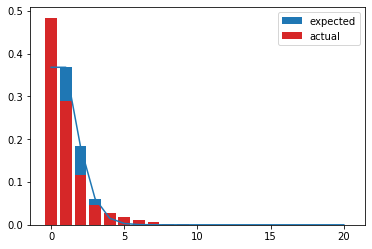

19
MWU: MannwhitneyuResult(statistic=133.0, pvalue=0.005434700476586038)


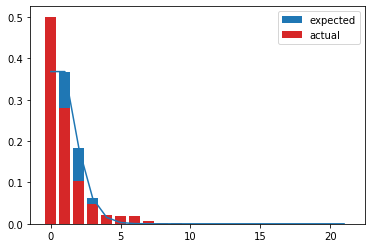

20
MWU: MannwhitneyuResult(statistic=197.0, pvalue=0.001931078555013984)


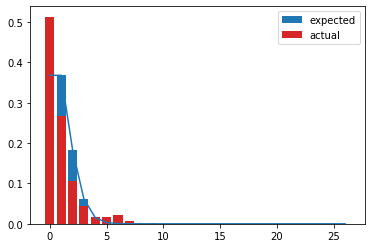

21
MWU: MannwhitneyuResult(statistic=243.0, pvalue=0.0011322502805564737)


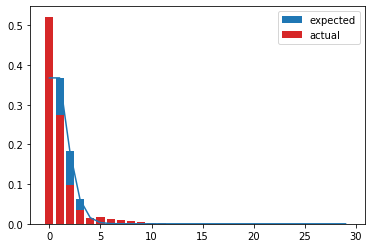

In [358]:
#Check for lambda = 1 and N = 2ˆ1 up to 2ˆ21
for i in range(4,22): 
    N = 2**i
    res = get_amounts_for_first(N,lamb=[1])
    print(i)
    analize_result(1,res[1],plot=True)

In [359]:
results = []
for i in range(4,18): 
    N = 2**i
    results.append(get_amounts_for_first(N,lamb=[i for i in range(1,21)]))
    print(i)


4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [360]:
for j in range(1,21):
    for i in range(len(results)):
        print("N: " + str(i) + " lambda: " + str(j))
        analize_result(1,results[i][j],plot=False)

N: 0 lambda: 1
MWU: MannwhitneyuResult(statistic=4.0, pvalue=0.5)
N: 1 lambda: 1
MWU: MannwhitneyuResult(statistic=4.0, pvalue=0.5)
N: 2 lambda: 1
MWU: MannwhitneyuResult(statistic=7.0, pvalue=0.44227471942648117)
N: 3 lambda: 1
MWU: MannwhitneyuResult(statistic=12.0, pvalue=0.5)
N: 4 lambda: 1
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)
N: 5 lambda: 1
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)
N: 6 lambda: 1
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)
N: 7 lambda: 1
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
N: 8 lambda: 1
MWU: MannwhitneyuResult(statistic=36.0, pvalue=0.36189765707468813)
N: 9 lambda: 1
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2601830104482655)
N: 10 lambda: 1
MWU: MannwhitneyuResult(statistic=62.0, pvalue=0.12953519666662766)
N: 11 lambda: 1
MWU: MannwhitneyuResult(statistic=94.0, pvalue=0.10330788479137654)
N: 12 lambda: 1
MWU: MannwhitneyuResult(statistic=111.0

MWU: MannwhitneyuResult(statistic=395.0, pvalue=0.000886801995252566)
N: 8 lambda: 19
MWU: MannwhitneyuResult(statistic=418.0, pvalue=0.00031421958019530393)
N: 9 lambda: 19
MWU: MannwhitneyuResult(statistic=380.0, pvalue=9.923574428696668e-06)
N: 10 lambda: 19
MWU: MannwhitneyuResult(statistic=445.0, pvalue=3.116560587099371e-07)
N: 11 lambda: 19
MWU: MannwhitneyuResult(statistic=468.0, pvalue=9.889888032155503e-08)
N: 12 lambda: 19
MWU: MannwhitneyuResult(statistic=507.0, pvalue=2.0013184352101932e-08)
N: 13 lambda: 19
MWU: MannwhitneyuResult(statistic=372.0, pvalue=9.577742672643905e-11)
N: 0 lambda: 20
MWU: MannwhitneyuResult(statistic=124.0, pvalue=0.0007979997416873942)
N: 1 lambda: 20
MWU: MannwhitneyuResult(statistic=285.0, pvalue=0.08343103682249425)
N: 2 lambda: 20
MWU: MannwhitneyuResult(statistic=343.0, pvalue=0.21151748064220294)
N: 3 lambda: 20
MWU: MannwhitneyuResult(statistic=380.0, pvalue=0.265487062431419)
N: 4 lambda: 20
MWU: MannwhitneyuResult(statistic=428.0, pvalu

MWU: MannwhitneyuResult(statistic=1277.0, pvalue=0.04546724123916899)


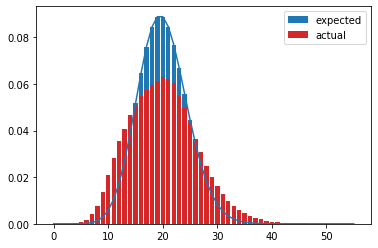

In [362]:
r = get_amounts_for_first(2**18,lamb=[20])
analize_result(20,r[20],plot=True)